# **IMPORTS**

In [1]:
%%capture 

!pip install -q lightgbm==4.5.0 --no-index --find-links=/kaggle/input/cmi2024-packages-v1/MLPackages
!pip install -q polars==1.7.1 --no-index --find-links=/kaggle/input/cmi2024-packages-v1/Polars171

In [2]:
%%writefile -a myimports.py

print(f"\n---> Commencing imports")

from gc import collect
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import display_html, clear_output
clear_output()
import os, sys, logging, re, joblib, ctypes, shutil
from copy import deepcopy

# General library imports:-
from os import path, walk, getpid
from psutil import Process
from collections import Counter
from itertools import product
import ctypes
libc = ctypes.CDLL("libc.so.6")

from IPython.display import display_html, clear_output
from pprint import pprint
from functools import partial
from copy import deepcopy
import pandas as pd, numpy as np
from scipy.optimize import minimize
from numpy.typing import ArrayLike, NDArray
import polars as pl
import polars.selectors as cs
from polars.testing import assert_frame_equal

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style, init
from tqdm.notebook import tqdm

Writing myimports.py


In [3]:
%%writefile -a myimports.py

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler,
                                   MinMaxScaler,
                                   StandardScaler,
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  )
from sklearn.impute import SimpleImputer as SI
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF,
                                     StratifiedKFold as SKF,
                                     StratifiedGroupKFold as SGKF,
                                     KFold,
                                     GroupKFold as GKF,
                                     RepeatedKFold as RKF,
                                     PredefinedSplit as PDS,
                                     cross_val_score,
                                     cross_val_predict,
                                    )
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold as VT
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import (BaseEstimator, TransformerMixin, RegressorMixin, clone)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import (mean_squared_error as mse, 
                             cohen_kappa_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                            )

# Importing model packages
import xgboost as xgb, lightgbm as lgb
from xgboost import QuantileDMatrix, XGBRegressor as XGBR
from lightgbm import log_evaluation, early_stopping, LGBMRegressor as LGBMR
from catboost import CatBoostRegressor as CBR, Pool

# Importing Ensemble and tuning packages
import optuna
from optuna import Trial, trial, create_study
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler, CmaEsSampler
optuna.logging.disable_default_handler()

Appending to myimports.py


In [4]:
%%writefile -a myimports.py

# Setting rc parameters in seaborn for plots and graphs-
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        }
       )

# Color printing
def PrintColor(text: str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string"
    print(style + color + text + Style.RESET_ALL)
 
# Checking package versions
import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}")
print(f"---> Sklearn = {sk.__version__}| Pandas = {pd.__version__} | Polars = {pl.__version__}")
collect()

Appending to myimports.py


In [5]:
%%writefile -a myimports.py

class MyLogger:
    """
    This class helps to suppress logs in lightgbm and Optuna
    Source - https://github.com/microsoft/LightGBM/issues/6014
    """

    def init(self, logging_lbl: str):
        self.logger = logging.getLogger(logging_lbl)
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        pass

    def warning(self, message):
        pass

    def error(self, message):
        self.logger.error(message)
        
        
# Customizing logging for XGBoost
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

stdout_handler = logging.StreamHandler(sys.stdout)
stdout_handler.setLevel(logging.INFO)
stdout_handler.setFormatter(formatter)

file_handler = logging.FileHandler(f'xgb_optimize.log')
file_handler.setLevel(logging.ERROR)
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)
logger.addHandler(stdout_handler)

class XGBLogging(xgb.callback.TrainingCallback):
    """
    This class designs the custom logging for XGboost 
    This is to be used inside the XGboost callback
    """

    def __init__(self, epoch_log_interval=100):
        self.epoch_log_interval = epoch_log_interval

    def after_iteration(
        self, model, epoch:int, evals_log:xgb.callback.TrainingCallback.EvalsLog
    ):
        if self.epoch_log_interval <= 0:
            pass
        
        elif (epoch %  self.epoch_log_interval == 0):
            for data, metric in evals_log.items():
                for metric_name, log in metric.items():
                    score = log[-1][0] if isinstance(log[-1], tuple) else log[-1]
                    logger.info(f"XGBLogging epoch {epoch} dataset {data} {metric_name} {score}")

        return False

Appending to myimports.py


In [6]:
%%time
exec(open('myimports.py','r').read())
print()

---> XGBoost = 2.0.3 | LightGBM = 4.5.0 | Catboost = 1.2.7
---> Sklearn = 1.2.2| Pandas = 2.2.2 | Polars = 1.7.1

CPU times: user 3.83 s, sys: 461 ms, total: 4.29 s
Wall time: 5.2 s


# **APPROACH DETAILS**

This is a starter notebook for the **Child Mind Institute — Problematic Internet Use** code competition. This is a time series tabular assignment to detect and classify the impact of excessive internet usage on child sleep patterns. We use **Quadratic Weighted Kappa Score** as evaluation metric. This needs to be maximized <br>

This kernel is a continuation of my [version1 baseline](https://www.kaggle.com/code/ravi20076/cmi2024-baseline-v1) where I illustrate the usage of proxy targets for the regression model. My approach here is based on the reference [here](https://www.kaggle.com/code/abdmental01/cmi-single-lgbm/notebook) <br>

We are provided a set of 3 datasets- <br> 
1. Parquet files for accelerometer train data, with separate tables for each id <br> 
2. Parquet files for accelerometer test data, with separate tables for each id <br>
3. Metadata for remaining information and a separate table for data dictionary <br> 

In this kernel, we start with the metadata and a few aggregate columns from the parquet file only and develop simple ML models as below- <br>
1. I directly aim to predict the **sii true target** using the features provided. I ignore the PCIAT_* proxy targets in this version <br>
2. I use lightgbm and xgboost models here and use a **custom objective** (Cohen Kappa loss) and the quadratic kappa eval metric for early stopping <br>
3. I use threshold tuning to convert continuous predictions into labels. I shall experiment with scipy.minimize/ Optuna tuner for the same <br>

### **MY NEW MODEL TRAINING CLASS** <br>
I am happy to present my new model trainer class here. I used to use a trainer class in my yester work, example is [here](https://www.kaggle.com/code/ravi20076/playgrounds4e09-baseline-v1) <br>
This code became a bit clunky and needed revision, hence I thought of shortening the code, making it more readable and introducing a few new parameters. <br>
This class supports single and multiple model entries and trains one model at a time. It also allows the user to choose an ensemble method of his/ her choice separate from the training process <br>



# **CONFIGURATION**

In [7]:
%%writefile -a training.py

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;

    # Data preparation:-
    version_nb  = 2
    model_id    = "V2_2"
    model_label = "ML"

    test_req           = False
    test_sample_frac   = 1000

    gpu_switch         = "OFF"
    state              = 42
    target             = f"sii"
    grouper            = f"sii"

    ip_path            = f"/kaggle/input/child-mind-institute-problematic-internet-use"
    op_path            = f"/kaggle/working"

    # Model Training:-
    pstprcs_oof        = False
    pstprcs_train      = False
    pstprcs_test       = False
    ML                 = True
    test_preds_req     = True

    pseudo_lbl_req     = False
    pseudolbl_up       = 0.975
    pseudolbl_low      = 0.00

    n_splits           = 3 if test_req == "Y" else 5
    n_repeats          = 1
    nbrnd_erly_stp     = 40
    mdlcv_mthd         = 'RSKF'

    # Ensemble:-
    ensemble_req       = True
    optuna_req         = True
    metric_obj         = 'maximize'
    ntrials            = 10 if test_req == "Y" else 300

    # Global variables for plotting:-
    grid_specs = {'visible'  : True,
                  'which'    : 'both',
                  'linestyle': '--',
                  'color'    : 'lightgrey',
                  'linewidth': 0.75
                 }

    title_specs = {'fontsize'   : 9,
                   'fontweight' : 'bold',
                   'color'      : '#992600',
                  }
    
cv_selector = \
{
 "RKF"   : RKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "RSKF"  : RSKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "SKF"   : SKF(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
 "KF"    : KFold(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
}

PrintColor(f"\n---> Configuration done!\n")
collect()

Writing training.py


|Configuration parameter| Explanation| Data type| Sample values |  
| ---------------------- | ------------------------------- | --------------------- | --------------- |
| version_nb    | Version Number | int | 1 | 
| model_id      | Model ID    | string | V1_1 | 
| model_label   | Model Label | string | ML | 
| test_req      | Test Required| bool | True / False | 
| test_sample_frac| Test sampled fraction | int | 1000 |
| gpu_switch      | Do we need GPU support | bool | True / False |
| state           | Random state | int | 42 |
| target          | Target column | str | sii |
| grouper         | CV grouper column | str | sii |
| ip_path, op_path | Data paths  | str | |
| pstprcs_* | Do we need post-processing  | bool |True / False |
| ML| Do we need machine learning models  | bool |True / False |
| test_preds_req| Do we need test set predictions (training in inference kernel)  | bool |True / False |
| pseudo_lbl_req| Pseudo label required?  | bool |True / False |
| pseudo_lbl_* | Pseudo label cutoff | float | |
| n_splits/ n_repeats | N-splits and repeats for CV scheme | int | 3/5/10|
| nbrnd_erly_stp | Early stopping rounds | int | 40|
| mdlcv_mthd | Model CV method | str | RSKF|
| ensemble_req | Do we need ensemble | bool | True / False |
| optuna_req   | Do we need optuna | bool | True / False |
| metric_obj   | Metric direction | str | minimize/ maximize |
| ntrials      | Trials | int | 300 |

In [8]:
%%writefile -a training.py

class Utils:
    """
    This class creates and uses several utility methods to be used across the code
    """;

    def __init__(self):
        pass

    def ScoreMetric(self, ytrue, ypred)-> float:
        """
        This method calculates the metric for the competition
        Inputs- ytrue, ypred:- input truth and predictions
        Output- float:- competition metric
        """
        myscore = \
        cohen_kappa_score(
            np.uint8(np.round(ytrue)), 
            np.uint8(np.round(ypred)), 
            weights = "quadratic"
        )
        return myscore

    def CleanMemory(self):
        "This method cleans the memory off unused objects and displays the cleaned state RAM usage"

        collect();
        libc.malloc_trim(0)
        pid        = getpid()
        py         = Process(pid)
        memory_use = py.memory_info()[0] / 2. ** 30
        return f"\nRAM usage = {memory_use :.4} GB"

    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """

        html_str = ''
        for df in args:
            html_str += df.to_html()
        display_html(html_str.replace('table','table style="display:inline"'),raw=True)
        collect()

    def DisplayScores(
        self, Scores: pd.DataFrame, TrainScores: pd.DataFrame, methods: list
    ):
        "This method displays the scores and their means"

        args = \
        [Scores.style.format(precision = 5).\
         background_gradient(cmap = "Blues", subset = methods + ["Ensemble"]).\
         set_caption(f"\nOOF scores across methods and folds\n"),

         TrainScores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = methods).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ];

        PrintColor(f"\n\n\n---> OOF score across all methods and folds\n",
                   color = Fore.LIGHTMAGENTA_EX
                   )
        self.DisplayAdjTbl(*args)

        print('\n')
        display(Scores.mean().to_frame().\
                transpose().\
                style.format(precision = 5).\
                background_gradient(cmap = "mako", axis=1,
                                    subset = Scores.columns
                                   ).\
                set_caption(f"\nOOF mean scores across methods and folds\n")
               )


utils = Utils()
collect()
print()

Appending to training.py


# **PREPROCESSING**

In [9]:
%%writefile -a training.py

class Preprocessor:
    "This class organizes the preprocessing steps for the train-test data into a single code block"
    
    def __init__(
        self, cat_imp_val : str= "missing", ip_path: str = CFG.ip_path
    ):
        self.cat_imp_val = cat_imp_val
        self.ip_path     = ip_path
        
    def make_pqfile_cols(
        self, verbose: bool = False, label: str = "Train"
    )->pl.DataFrame:
        "This method collates the id level parquet files and creates the aggregation columns in a polars dataframe"

        cols = ["X", "Y", "Z", "enmo", "anglez", "light", "battery_voltage"]
        
        ip_path   = os.path.join(self.ip_path, f"series_{label.lower()}.parquet")
        all_files = os.listdir(ip_path)

        for file_nb, file in tqdm(enumerate(all_files)):
            df = \
            pl.scan_parquet(
                os.path.join(ip_path, file, f"part-0.parquet")
            ).select(pl.col(cols)).\
            collect().\
            describe(
                percentiles = np.arange(0.05, 0.95, 0.10)
            ).\
            filter(~pl.col("statistic").is_in(["count", "null_count"])).\
            unpivot(index = "statistic").\
            with_columns(
                pl.concat_str([pl.col("variable"), pl.col("statistic")],separator = "_",).alias("myvar")
            ).\
            with_columns(pl.col("myvar").str.replace(r"\%", "")).\
            select(["myvar", "value"]).\
            transpose(column_names = "myvar").\
            select(pl.all().shrink_dtype()).\
            with_columns(
                pl.Series("id", np.array(re.sub("id=", "", file)))
            )

            if file_nb == 0:
                op_df = df.clone()
            elif file_nb > 0:
                op_df = pl.concat([op_df, df], how = "vertical_relaxed")

                if verbose:
                    print(f"---> Shapes = {op_df.shape}")
                else:
                    pass
            del df

        PrintColor(f"---> {label} - shape = {op_df.shape}", color = Fore.CYAN)
        return op_df

    def pp_data(
        self, df: pl.DataFrame, label: str = "Train", cat_cols: list = [], 
    ):
        "This method preprocesses the train-test data with requisite steps"
        
        PrintColor(f"\n --- Data Processing - {label} --- \n")
        PrintColor(f"---> Shape = {df.shape} - memory usage {df.estimated_size('mb') :.3f} MB", 
                   color = Fore.CYAN
                  )
        
        if label == "Train":
            cat_cols = df.select(cs.string().exclude("id")).columns
        else:
            pass
        
        df    = df.with_columns(pl.col(cat_cols).fill_null(self.cat_imp_val).cast(pl.Categorical))
        op_df = self.make_pqfile_cols(label = label)
        df    = df.join(op_df, how = "left", on = "id")
        df    = df.select(pl.all().shrink_dtype())
        del op_df
        
        PrintColor(f"---> Shape = {df.shape} - memory usage {df.estimated_size('mb') :.3f} MB", 
                   color = Fore.CYAN
                  )
        return df, cat_cols
        

Appending to training.py


In [10]:
%%time 

exec(open('training.py','r').read())
train  = pl.read_csv(os.path.join(CFG.ip_path, "train.csv")).drop("PCIAT-Season", strict = False)
test   = pl.read_csv(os.path.join(CFG.ip_path, "test.csv"))
sub_fl = pl.read_csv(os.path.join(CFG.ip_path, "sample_submission.csv"))

pp    = Preprocessor()
train, cat_cols = pp.pp_data(train, "Train")
test, _  = pp.pp_data(test, "Test", cat_cols)
sel_cols = test.drop("id", strict = False).columns

print()
_ = utils.CleanMemory()


---> Configuration done!



 --- Data Processing - Train --- 

---> Shape = (3960, 81) - memory usage 2.309 MB


0it [00:00, ?it/s]

---> Train - shape = (996, 92)
---> Shape = (3960, 172) - memory usage 2.194 MB

 --- Data Processing - Test --- 

---> Shape = (20, 59) - memory usage 0.008 MB


0it [00:00, ?it/s]

---> Test - shape = (2, 92)
---> Shape = (20, 150) - memory usage 0.011 MB

CPU times: user 5min 44s, sys: 15.6 s, total: 6min
Wall time: 2min 32s


# **MODEL TRAINING**

In [11]:
%%writefile -a training.py

class ModelTrainer:
    "This class trains the provided model on the train-test data and returns the predictions and fitted models"

    def __init__(
        self,
        es_req         : bool  = False,
        es             : int   = 100,
        target         : str   = CFG.target,
        metric_lbl     : str   = "kappa",
        drop_cols      : list  = ["Source", "id", "Id", "Label", CFG.target, "fold_nb"],
    ):
        """
        Key parameters-
        es_iter - early stopping rounds for boosted trees
        """
        
        drop_cols = list(set(drop_cols + [target]))
        
        self.es_req         = es_req
        self.es_iter        = es
        self.target         = target
        self.drop_cols      = drop_cols
        self.metric_lbl     = metric_lbl
        
    def ScoreMetric(self, ytrue, ypred)->float:
        """
        This is the metric function for the competition scoring
        """
        if self.metric_lbl == "rmse":
            return mse(ytrue, ypred, squared = False)
        
        elif self.metric_lbl == "kappa":
            myscore = \
            cohen_kappa_score(
                np.uint8(np.around(ytrue,0)),
                np.uint8(np.around(ypred,0)),
                weights = "quadratic",
            )
            return myscore

    def PlotFtreImp(
        self, ftreimp: pd.Series, method: str,
        ntop: int = 50,
        title_specs: dict = CFG.title_specs,
        **params,
    ):
        "This function plots the feature importances for the model provided"

        print()
        fig, ax = plt.subplots(1, 1, figsize = (25, 7.5))

        ftreimp.sort_values(ascending = False).\
        head(ntop).\
        plot.bar(ax = ax, color = "blue")
        ax.set_title(f"Feature Importances - {method}", **title_specs)

        plt.tight_layout()
        plt.show()
        print()

    def PostProcessPreds(self, ypred):
        "This method post-processes predictions optionally"
        return np.clip(ypred, a_min = 0, a_max = np.inf)

    def MakeOfflineModel(
        self, X, y, ygrp, Xtest, mdl, method,
        test_preds_req   : bool = True,
        ftreimp_plot_req : bool = True,
        ntop             : int  = 50,
        **params,
    ):
        """
        This function trains the provided model on the dataset and cross-validates appropriately

        Inputs-
        X, y, ygrp       - training data components
        Xtest            - test data
        model            - model object for training
        method           - model method label
        test_preds_req   - boolean flag to extract test set predictions
        ftreimp_plot_req - boolean flag to plot tree feature importances
        ntop             - top n features for feature importances plot

        Returns-
        oof_preds, test_preds - prediction arrays
        fitted_models         - fitted model list for test set
        ftreimp               - feature importances across selected features
        mdl_best_iter         - model average best iteration across folds
        """

        oof_preds     = np.zeros(len(X))
        test_preds    = []
        mdl_best_iter = []
        ftreimp       = 0
        
        scores, tr_scores, fitted_models = [], [], []
        cv = PDS(ygrp)
        n_splits = ygrp.nunique()

        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(cv.split(X, y))):
            Xtr   = X.iloc[train_idx]
            Xdev  = X.iloc[dev_idx]
            ytr   = y.iloc[train_idx]
            ydev  = y.iloc[dev_idx]
            model = clone(mdl)

            if "CB" in method and self.es_req == True:
                model.fit(Xtr, ytr,
                          eval_set = [(Xdev, ydev)],
                          verbose = 0,
                          early_stopping_rounds = self.es_iter,
                          )
                best_iter = model.get_best_iteration()

            elif "LGB" in method and self.es_req == True:
                model.fit(Xtr, ytr,
                          eval_set = [(Xdev, ydev)],
                          callbacks = [log_evaluation(0),
                                       early_stopping(stopping_rounds = self.es_iter, verbose = False,),
                                       ],
                          eval_metric = MakeEvalMetric,
                          )
                best_iter = model.best_iteration_

            elif "XGB" in method and self.es_req == True:
                model.fit(Xtr, ytr,
                          eval_set = [(Xdev, ydev)],
                          verbose  = 0,
                          )
                best_iter = model.best_iteration

            else:
                model.fit(Xtr, ytr)
                best_iter = -1

            fitted_models.append(model)

            try:
                ftreimp += model.feature_importances_
            except:
                pass

            dev_preds = self.PostProcessPreds(model.predict(Xdev))
            oof_preds[Xdev.index] = dev_preds

            train_preds  = self.PostProcessPreds(model.predict(Xtr))
            tr_score     = self.ScoreMetric(ytr.values.flatten(), train_preds)
            score        = self.ScoreMetric(ydev.values.flatten(), dev_preds)

            scores.append(score)
            tr_scores.append(tr_score)

            nspace = 15 - len(method) - 2 if fold_nb <= 9 else 15 - len(method) - 1
            
            if self.es_req:
                PrintColor(f"{method} Fold{fold_nb} {' ' * nspace} OOF = {score:.6f} | Train = {tr_score:.6f} | Iter = {best_iter:,.0f} ")
            else:
                PrintColor(f"{method} Fold{fold_nb} {' ' * nspace} OOF = {score:.6f} | Train = {tr_score:.6f}")
                
            mdl_best_iter.append(best_iter)

            if test_preds_req:
                test_preds.append(
                    self.PostProcessPreds(
                        model.predict(Xtest)
                    )
                )
            else:
                pass

        test_preds    = np.mean(np.stack(test_preds, axis = 1), axis=1)
        ftreimp       = pd.Series(ftreimp, index = Xdev.columns)
        mdl_best_iter = np.uint16(np.amax(mdl_best_iter))

        if ftreimp_plot_req :
            print()
            self.PlotFtreImp(ftreimp, method = method, ntop = ntop,)
        else:
            pass

        PrintColor(f"\n---> {np.mean(scores):.6f} +- {np.std(scores):.6f} | OOF", color = Fore.RED)
        PrintColor(f"---> {np.mean(tr_scores):.6f} +- {np.std(tr_scores):.6f} | Train", color = Fore.RED)

        if self.es_req == False:
            pass
        else:
            PrintColor(f"---> Max best iteration = {mdl_best_iter :,.0f}", color = Fore.RED)

        return (fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter)

    def MakeOnlineModel(
        self, X, y, Xtest, model, method,
        test_preds_req : bool = False,
    ):
        "This method refits the model on the complete train data and returns the model fitted object and predictions"

        try:
            model.early_stopping_rounds = None
        except:
            pass

        try:
            model.fit(X, y, verbose = 0)
        except:
            model.fit(X, y,)

        oof_preds  = model.predict(X)
        if test_preds_req:
            test_preds = model.predict(Xtest[X.columns])
        else:
            test_preds = 0
        return (model, oof_preds, test_preds)

    def MakeOfflinePreds(self, X, fitted_models):
        "This method creates test-set predictions for the offline model provided"

        test_preds = 0
        n_splits   = len(fitted_models)
        PrintColor(f"---> Number of splits = {n_splits}")

        for model in fitted_models:
            test_preds = test_preds + (model.predict(X) / n_splits)

        return test_preds

Appending to training.py


In [12]:
%%writefile -a training.py

class OptunaEnsembler:
    """
    This is the Optuna ensemble class-
    Source- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass
    """;

    def __init__(
        self, state: int = 42, ntrials: int = 300, 
        metric_obj: str  = "maximize", 
        metric_lbl: str  = "kappa",
        **params
    ):
        self.study        = None
        self.weights      = None
        self.random_state = state
        self.n_trials     = ntrials
        self.direction    = metric_obj
        self.metric_lbl   = metric_lbl

    def ScoreMetric(self, ytrue, ypred)->float:
        """
        This is the metric function for the competition
        """
        
        if self.metric_lbl == "rmse":
            return mse(ytrue, ypred, squared = False)
        else:
            myscore = \
            cohen_kappa_score(
                np.uint8(np.around(ytrue,0)),
                np.uint8(np.around(ypred,0)), 
                weights = "quadratic"
            )
            return myscore

    def _objective(
        self, trial, y_true, y_preds
    ):
        """
        This method defines the objective function for the ensemble
        """;

        if isinstance(y_preds, pd.DataFrame) or isinstance(y_preds, np.ndarray):
            weights = [trial.suggest_float(f"weight{n}", 0.001, 0.999)
                       for n in range(y_preds.shape[-1])
                      ]
            axis = 1

        elif isinstance(y_preds, list):
            weights = [trial.suggest_float(f"weight{n}", 0.001, 0.999)
                       for n in range(len(y_preds))
                      ]
            axis = 0

        # Calculating the weighted prediction:-
        weighted_pred  = np.average(np.array(y_preds), axis = axis, weights = weights)
        score          = self.ScoreMetric(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";

        optuna.logging.set_verbosity = optuna.logging.ERROR

        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state),
                            pruner     = HyperbandPruner(),
                            study_name = "Ensemble",
                            direction  = self.direction,
                           )

        obj = partial(self._objective, y_true = y_true, y_preds = y_preds)
        self.study.optimize(obj, n_trials = self.n_trials)

        if isinstance(y_preds, list):
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

        else:
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(y_preds.shape[-1])]

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";

        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict';

        if isinstance(y_preds, list):
            weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights)

        else:
            weighted_pred = np.average(np.array(y_preds), axis=1, weights = self.weights)

        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        """
        This method fits the Optuna objective on the fold data, then predicts the test set
        """;
        self.fit(y_true, y_preds)
        return self.predict(y_preds)

    def weights(self):
        "This method returns the non-normalized weights for all models in a fold"
        return self.weights

print()
collect();

Appending to training.py


In [13]:
%%writefile -a training.py

def NormWeights(weights: dict, methods: list):
    "This function normalizes the weights and returns a dataframe of normalized weights across folds and models"

    weights = pd.DataFrame.from_dict(weights).T
    weights["row_sum"] = weights.sum(axis=1)

    for col in weights.columns:
        weights[col] = weights[col] / weights["row_sum"]

    weights.drop("row_sum", axis = 1, inplace = True, errors = "ignore")
    weights.columns    = methods
    weights.index.name = "Fold_Nb"
    return weights

def MakeEnsemble(
    target: str, metric_obj: str, metric_lbl: str = "kappa"
):
    "This function implements the Optuna ensemble on the OOF and test prediction datasets"

    global OOF_Preds, Mdl_Preds

    PrintColor(f"\n{'=' * 20} ENSEMBLE {'=' * 20}\n")
    
    ygrp       = OOF_Preds["fold_nb"]
    cv         = PDS(ygrp)
    oof_preds  = np.zeros(len(OOF_Preds))
    test_preds = []
    scores     = []
    weights    = {}
    drop_cols  = ["fold_nb", target, "Ensemble"]
    n_splits   = ygrp.nunique()

    for fold_nb, (_, dev_idx) in tqdm(enumerate(cv.split(OOF_Preds, OOF_Preds[target]))):
        Xdev = OOF_Preds.iloc[dev_idx].drop(drop_cols, axis=1, errors = "ignore")
        ydev = OOF_Preds.loc[dev_idx, target]

        ens = OptunaEnsembler(
            ntrials = CFG.ntrials, metric_lbl = metric_lbl, metric_obj = metric_obj
        )
        ens.fit(ydev, Xdev,)

        dev_preds = ens.predict(Xdev)
        score     = ens.ScoreMetric(ydev.values, dev_preds)
        oof_preds[dev_idx] = dev_preds
        test_preds.append(
            ens.predict(Mdl_Preds.drop(drop_cols, axis=1, errors = "ignore"))
        )

        PrintColor(f"---> {score: .6f} | Fold {fold_nb}", color = Fore.CYAN)
        scores.append(score)

        weights[f"Fold{fold_nb}"] = ens.weights

    PrintColor(f"\n---> OOF = {np.mean(scores): .6f} +- {np.std(scores): .6f} | Ensemble",
               color = Fore.RED
              )

    test_preds = np.mean(np.stack(test_preds, axis=1), axis=1,)

    OOF_Preds["Ensemble"] = oof_preds
    Mdl_Preds["Ensemble"] = test_preds

    weights = \
    NormWeights(
        weights,
        methods = Mdl_Preds.drop(drop_cols, axis=1, errors = "ignore").columns
    )

    print("\n\n\n")
    display(
        weights.\
        style.\
        set_caption("Normalized weights").\
        format(precision = 6).\
        set_properties(
            props = "color:red; background-color:white; font-weight: bold; border: maroon dashed 1.6px"
        )
    )
    
    print()
    display(
        weights.mean().to_frame().transpose().\
        style.\
        format(precision = 6).\
        set_caption("Normalized Mean weights").\
        set_properties(
            props = "color:red; background-color:white; font-weight: bold; border: maroon dashed 1.6px"
        )        
    )

    return weights


Appending to training.py


In [14]:
%%writefile -a training.py

class OptimizedRounder:
    """
    Source - https://www.kaggle.com/code/tubotubo/starter-notebook-multi-target-prediction
    """

    def __init__(
        self, n_classes: int, n_trials: int = 100, direction : str = "maximize"
    ):
        self.n_classes  = n_classes
        self.labels     = np.arange(n_classes)
        self.n_trials   = n_trials
        self.metric     = partial(cohen_kappa_score, weights="quadratic")
        self.direction  = direction
        
    def _objective(
        self, trial: optuna.Trial, y_true: NDArray[np.int_], y_pred: NDArray[np.float_],
    ) -> float:
        
        thresholds = []
        for i in range(self.n_classes - 1):
            low  = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            th   = trial.suggest_float(f"threshold_{i}", low, high)
            thresholds.append(th)
            
        try:
            y_pred_rounded = np.digitize(y_pred, thresholds)
        except ValueError:
            return -100
        return self.metric(y_true, y_pred_rounded)

    def fit(
        self, y_pred: NDArray[np.float_], y_true: NDArray[np.int_]
    ) -> None:
        y_pred = self._normalize(y_pred)
        study  = optuna.create_study(direction = self.direction)
        obj    = partial(self._objective, y_true = y_true, y_pred = y_pred)
        
        study.optimize(obj, n_trials = self.n_trials)
        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
        assert hasattr(self, "thresholds"), "fit() must be called before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: NDArray[np.float_]) -> NDArray[np.float_]:
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)
    
    def thresholds(self):
        return self.thresholds


Appending to training.py


## **MODEL I-O**

In [15]:
%%writefile -a training.py

a = 2.998
b = 1.092

def MakeObj(y_true, y_pred):
    "This function is the common custom objective for LGBM and XGB"
    
    labels = y_true + a
    preds  = y_pred + a
    preds  = preds.clip(0, np.inf)
    f      = 1/2*np.sum((preds-labels)**2)
    g      = 1/2*np.sum((preds-a)**2+b)
    df     = preds - labels
    dg     = preds - a
    grad   = (df/g - f*dg/g**2)*len(labels)
    hess   = np.ones(len(labels))
    
    return grad, hess

def MakeEvalMetric(y_true, y_pred):
    
    if isinstance(y_pred, xgb.QuantileDMatrix):
        y_true, y_pred = y_pred, y_true
        y_true = (y_true.get_label() + a).round()
        y_pred = (y_pred + a).clip(0, np.inf).round()
        
        qwk = cohen_kappa_score(np.int8(y_true), np.int8(y_pred), weights="quadratic")
        return 'QWK', qwk

    else:
        y_true = y_true + a
        y_pred = (y_pred + a).clip(0, np.inf).round()
        
        qwk = cohen_kappa_score(np.int8(y_true), np.int8(y_pred), weights="quadratic")
        return 'QWK', qwk, True

Appending to training.py


In [16]:
%%capture

exec(open('training.py','r').read())

try:
    l = MyLogger()
    l.init(logging_lbl = "lightgbm_custom")
    lgb.register_logger(l)
except:
    pass

# Initializing CV scheme
cv = cv_selector[CFG.mdlcv_mthd]

# Initializing model parameters
Mdl_Master = \
{
 f'LGBM1R' : LGBMR(**{"objective"           : MakeObj,
                      "metrics"             : "None",
                      'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                      'learning_rate'       : 0.025, 
                      'n_estimators'        : 270,
                      'max_depth'           : 6, 
                      'num_leaves'          : 85, 
                      'min_data_in_leaf'    : 12,
                      'feature_fraction'    : 0.70, 
                      'bagging_fraction'    : 0.88, 
                      'bagging_freq'        : 6, 
                      'lambda_l1'           : 9.92, 
                      'lambda_l2'           : 4.35,
                      'verbosity'           : -1,
                      'random_state'        : CFG.state,
                     }
                  ),
    
 f'XGB1R' : XGBR(**{  "objective"           : MakeObj,
                      'device'              : "cuda" if CFG.gpu_switch == "ON" else "cpu",
                      'learning_rate'       : 0.03, 
                      'n_estimators'        : 200,
                      'max_depth'           : 4, 
                      'colsample_bytree'    : 0.55, 
                      'colsample_bynode'    : 0.60,
                      'colsample_bylevel'   : 0.70,                     
                      'reg_alpha'           : 2.50, 
                      'reg_lambda'          : 7.50,
                      'verbose'             : 0,
                      'random_state'        : CFG.state,
                      'enable_categorical'  : True,
                      'callbacks'           : [XGBLogging(epoch_log_interval= 0)],
                     }
                  ),
}

# Initializing model outputs
OOF_Preds    = {}
Mdl_Preds    = {}
FittedModels = {}
FtreImp      = {}
SelMdlCols   = {}

## **MODEL CV ANALYSIS**

In [17]:
%%time 

mytrain  = train.to_pandas().dropna(subset = [CFG.target])
mytest   = test.to_pandas()[sel_cols]
mytarget = CFG.target

mytrain.index = range(len(mytrain))
PrintColor(f"---> Shapes = {mytrain.shape} {mytest.shape}", color = Fore.CYAN)

# Initializing CV folds across the training data:-
folds = np.zeros(len(mytrain))
for fold_nb, (train_idx, dev_idx) in enumerate(cv.split(mytrain, mytrain[mytarget])):
    folds[dev_idx] = fold_nb
mytrain["fold_nb"] = folds
del folds

PrintColor(f"---> Shapes = {mytrain.shape} {mytest.shape}\n\n", color = Fore.CYAN)

---> Shapes = (2736, 172) (20, 149)
---> Shapes = (2736, 173) (20, 149)


CPU times: user 46.3 ms, sys: 13.3 ms, total: 59.6 ms
Wall time: 66.6 ms


  0%|          | 0/2 [00:00<?, ?it/s]


---------- LGBM1R MODEL TRAINING - sii ----------



0it [00:00, ?it/s]

LGBM1R Fold0         OOF = 0.387240 | Train = 0.694219
LGBM1R Fold1         OOF = 0.480202 | Train = 0.686213
LGBM1R Fold2         OOF = 0.432703 | Train = 0.690152
LGBM1R Fold3         OOF = 0.373887 | Train = 0.699913
LGBM1R Fold4         OOF = 0.433157 | Train = 0.702356




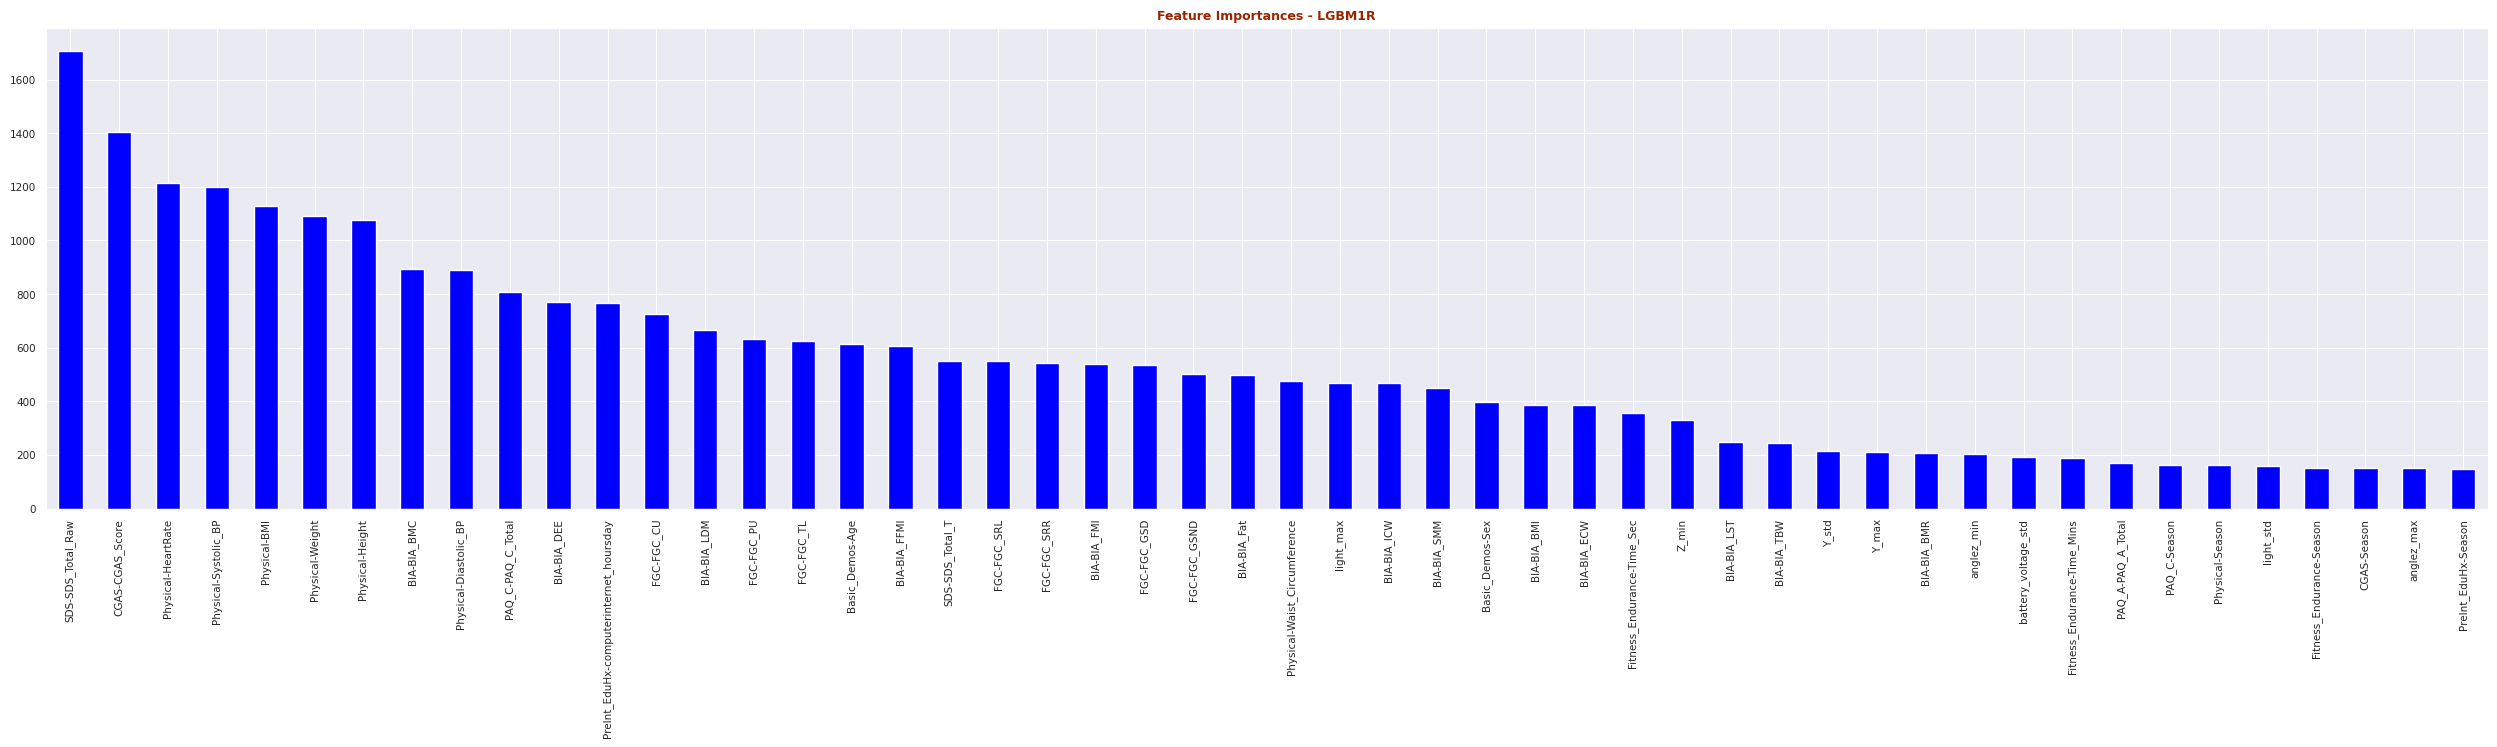



---> 0.421438 +- 0.037810 | OOF
---> 0.694571 +- 0.005977 | Train

---------- XGB1R MODEL TRAINING - sii ----------



0it [00:00, ?it/s]

XGB1R Fold0          OOF = 0.397823 | Train = 0.590436
XGB1R Fold1          OOF = 0.415194 | Train = 0.587791
XGB1R Fold2          OOF = 0.381230 | Train = 0.608174
XGB1R Fold3          OOF = 0.375455 | Train = 0.606626
XGB1R Fold4          OOF = 0.404636 | Train = 0.612787




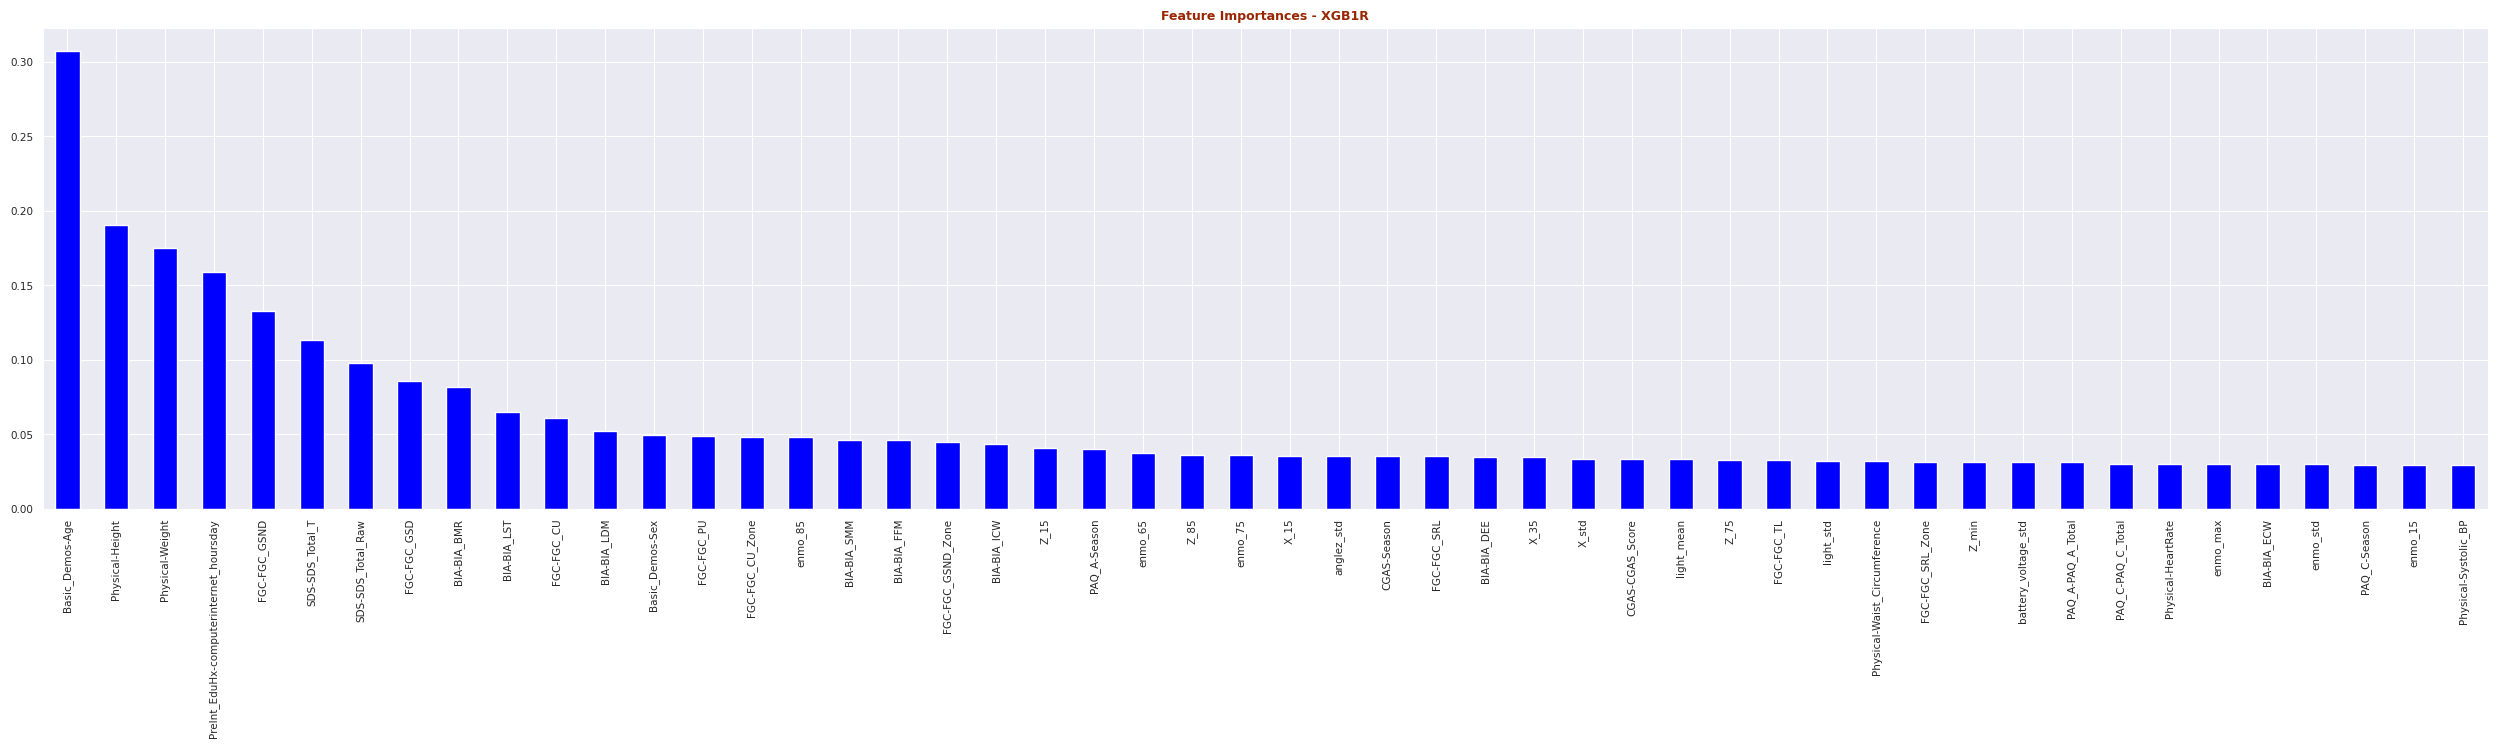



---> 0.394868 +- 0.014698 | OOF
---> 0.601163 +- 0.010080 | Train

RAM usage = 0.535 GB
CPU times: user 31.1 s, sys: 824 ms, total: 32 s
Wall time: 30.7 s


In [18]:
%%time 
      
# Creating CV scheme:-
md = ModelTrainer(es = CFG.nbrnd_erly_stp, target = mytarget)

for method, mdl in tqdm(Mdl_Master.items()):
    PrintColor(f"\n{'-' * 10} {method} MODEL TRAINING - {mytarget} {'-' * 10}\n", 
               color = Fore.MAGENTA
              )

    fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter =  \
    md.MakeOfflineModel(
        mytrain[sel_cols],
        mytrain[mytarget],
        mytrain["fold_nb"],
        mytest,
        clone(mdl),
        method,
        test_preds_req   = True,
        ftreimp_plot_req = True,
        ntop = 50,
    ) 

    # Integrating data    
    OOF_Preds[f"{method}"]    = oof_preds
    Mdl_Preds[f"{method}"]    = test_preds
    FtreImp[f"{method}"]      = ftreimp
    FittedModels[f"{method}"] = fitted_models

    del fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter
    _ = utils.CleanMemory()
    
PrintColor(utils.CleanMemory())    

# **ENSEMBLE**

In [19]:
%%time 

OOF_Preds = pd.DataFrame.from_dict(OOF_Preds, orient = "columns")
Mdl_Preds = pd.DataFrame.from_dict(Mdl_Preds, orient = "columns")

OOF_Preds[mytarget]  = mytrain[mytarget].values
OOF_Preds["fold_nb"] = mytrain["fold_nb"].values

weights = \
MakeEnsemble(target = mytarget, metric_obj = CFG.metric_obj, metric_lbl = 'kappa')

print()
PrintColor(utils.CleanMemory())


==================== ENSEMBLE ====================



0it [00:00, ?it/s]

--->  0.397823 | Fold 0
--->  0.485323 | Fold 1
--->  0.435744 | Fold 2
--->  0.379018 | Fold 3
--->  0.433239 | Fold 4

---> OOF =  0.426230 +-  0.036517 | Ensemble






,LGBM1R,XGB1R
Fold_Nb,,
Fold0,0.008862,0.991138
Fold1,0.937033,0.062967
Fold2,0.779307,0.220693
Fold3,0.597022,0.402978
Fold4,0.979776,0.020224


,LGBM1R,XGB1R
0,0.660400,0.339600




RAM usage = 0.5364 GB
CPU times: user 31.5 s, sys: 39.1 ms, total: 31.5 s
Wall time: 31.5 s


# **THRESHOLD TUNING**

In this section, we try and establish the best CV based cutoffs to convert the continuous predictions to labels for the target prediction <br>
Here, we use the predicted values for the true target and unearth the best values for **sii** labels

---> Thresholds for labels
array([0.80547, 1.71358, 2.33151])

---> Final ensemble OOF score = 0.462166




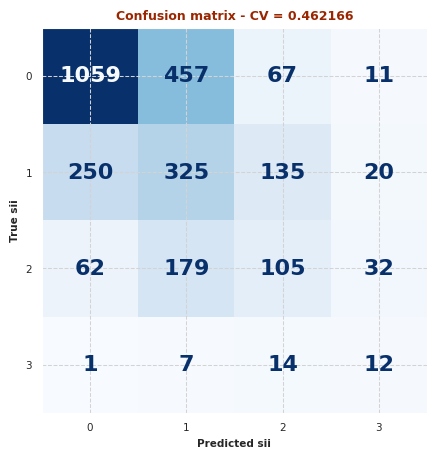

CPU times: user 9.01 s, sys: 75.6 ms, total: 9.08 s
Wall time: 9.08 s


In [20]:
%%time 

mytuner = OptimizedRounder(n_classes = 4, n_trials = CFG.ntrials)
ytrain  = np.uint8(mytrain[CFG.target])

mytuner.fit(OOF_Preds["LGBM1R"], ytrain)
ens_preds  = mytuner.predict(OOF_Preds["LGBM1R"])
test_preds = mytuner.predict(Mdl_Preds["LGBM1R"])

PrintColor(f"---> Thresholds for labels")
with np.printoptions(linewidth = 100, precision = 5):
    pprint(np.array(mytuner.thresholds))

# Displaying the confusion matrix 
score = utils.ScoreMetric(ytrain, ens_preds)
PrintColor(f"\n---> Final ensemble OOF score = {score :.6f}\n\n")

fig, ax = plt.subplots(1,1, figsize = (5,5))
disp = \
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytrain, ens_preds),  
    display_labels = list(range(4))
)

disp.plot(
    cmap = "Blues", 
    ax = ax, 
    colorbar = False, 
    xticks_rotation = 0,
    text_kw = {"fontweight": "bold",  
               "fontsize"  : 16,
              }
)
ax.set_title(
    f"Confusion matrix - CV = {score :.6f}", **CFG.title_specs
)
ax.grid(**CFG.grid_specs)
ax.set(ylabel = f"True {CFG.target}", 
       xlabel = f"Predicted {CFG.target}", 
      )
plt.show()

_ = utils.CleanMemory()

# **SUBMISSION**

In [21]:
%%time 

try:
    print()
    display(
        OOF_Preds.head().style.format(precision = 3).set_caption("OOF Predictions")
    )

    print()
    display(
        Mdl_Preds.head().style.format(precision = 3).set_caption("Model Predictions")
    )
except:
    pass

sub_fl.with_columns(
    pl.Series(CFG.target, test_preds.flatten(), pl.UInt8)
).write_csv("submission.csv")

print()
!ls 
print(f"\n\n---> Submission file\n\n")
!head submission.csv

PrintColor(utils.CleanMemory())

,LGBM1R,XGB1R,sii,fold_nb,Ensemble
0,0.478,0.663,2.000,3.000,0.553
1,0.341,0.349,0.000,3.000,0.345
2,0.823,0.757,0.000,0.000,0.758
3,0.357,0.418,1.000,0.000,0.417
4,0.768,0.712,1.000,3.000,0.745


,LGBM1R,XGB1R,Ensemble
0,0.753,0.769,0.758
1,0.289,0.304,0.294
2,0.606,0.647,0.620
3,0.554,0.455,0.520
4,0.878,0.740,0.831



myimports.py  submission.csv  training.py  xgb_optimize.log


---> Submission file


id,sii
00008ff9,2
000fd460,0
00105258,1
00115b9f,1
0016bb22,2
001f3379,3
0038ba98,1
0068a485,1
0069fbed,3

RAM usage = 0.5381 GB
CPU times: user 243 ms, sys: 48.2 ms, total: 291 ms
Wall time: 2.59 s
